<a href="https://colab.research.google.com/github/angel870326/XLNet_Text_Classification/blob/main/product/xlnet_multi_class_chinese_product_single_label_bcel_oversample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 2022.06.09 Ssu-Yun Wang<br/>
[Github @angel870326](https://github.com/angel870326)

# **XLNet Multi-class Text Classification for Chinese and English**
Available for both multi-label and single-label classification.

## **Contents**
1. Dataset
   *   Cleaned dataset (with oversampling)
   *   Convert 'product' to dummy variables
   *   Get small sample of train and test to try (optional)
<br/>
2. Preprocessing<br/>
   (1) XLNetTokenizer & Sentence embedding<br/>
   (2) Tokenize input texts into ids<br/>
   (3) Create attention masks<br/>
   (4) Add input ids and attention masks to the dataframe<br/>
3. **Train, Valid Split (2022.06.09 updated)**<br/>
4. Create Dataloaders (torch tensors)<br/>
5. Training<br/>
   (1) Functions<br/>
   (2) Train model from scratch<br/>
   (3) Train model from previous checkpoint<br/>
6. Get Predictions<br/>
   (1) Testing<br/>
   (2) For single-label classification<br/>
   (3) Save the predicting results<br/>
7. **Evaluate Validation Set (new)**<br/>
   **(1) Predicting**<br/>
   **(2) Evaluation**<br/>


** Modified from  https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df*

In [ ]:
!pip install transformers
# !pip install sentencepiece # for English

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 11.8 MB/s 
     |████████████████████████████████| 596 kB 45.7 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import math
import torch
# from torch.nn import CrossEntropyLoss # for single-label
from torch.nn import BCEWithLogitsLoss # for multi-label
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# GPU
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


## **1. Dataset**


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Cleaned dataset

In [ ]:
train_raw = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/資料集/category_clean1_oversample.csv')
test = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/資料集/test/category_test.csv')

In [ ]:
train_data = {'id': range(1, len(train_raw) + 1),
              'name': train_raw['name'],
              'product': train_raw['product']}
train_clean = pd.DataFrame(train_data)
train_clean.head()

,id,name,product
0,1,槓片短槓心a,槓片
1,2,體育刻tuk奧林匹克槓片 – 125 25 5 kg tuk,槓片
2,3,槓片短槓心a,槓片
3,4,槓片短槓心a,槓片
4,5,體育刻tuk奧林匹克槓片 – 125 25 5 kg tuk,槓片


In [ ]:
# number of classes
class_num = train_clean['product'].nunique() 
class_num

216

In [ ]:
test.head()

,id,name,product
0,1,施巴嬌顏卸妝乳ha,NaN
1,2,艾瑪絲舒敏平衡洗髮精,NaN
2,3,bb love高質感天絲tencel舖棉兩用兒童睡袋多款可選,NaN
3,4,lovita愛維他緩釋型維生素c,NaN
4,5,cm 長效rifle風扇 1200轉,NaN


### Convert 'product' to dummy variables

In [ ]:
train_valid = train_clean[['id', 'name', 'product']]
products = pd.get_dummies(train_clean['product'])
train_valid = pd.concat([train_valid, products], axis=1)
train_valid

,id,name,product,BB霜,CC霜,DD霜,RTD調酒,中式香腸,乳酸菌,人工淚液,...,電磁爐,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類
0,1,槓片短槓心a,槓片,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,體育刻tuk奧林匹克槓片 – 125 25 5 kg tuk,槓片,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,槓片短槓心a,槓片,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,槓片短槓心a,槓片,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,體育刻tuk奧林匹克槓片 – 125 25 5 kg tuk,槓片,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94137,94138,mdmmd微醺心機漸層腮紅玫瑰瑪格麗特,腮紅,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94138,94139,mdmmd微醺心機漸層腮紅橙酒,腮紅,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94139,94140,倫敦芮魅 叛逆玩色腮紅盤005 微醺酒紅,腮紅,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94140,94141,palladio柔光幻彩貝殼腮紅微醺蜜桃,腮紅,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get small sample of train and test to try (optional)

In [ ]:
# train_valid = train_valid.sample(n=1000)
# test = test.sample(n=100)

## **2. Preprocessing**


---



### (1) XLNetTokenizer & Sentence embedding

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
# XLNetTokenizer (for English)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

# AutoTokenizer (for Chinese)
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-xlnet-base")

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/671 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/675k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/202 [00:00<?, ?B/s]

In [ ]:
# Texts for classification
train_text_list = train_valid['name'].values
test_text_list = test['name'].values

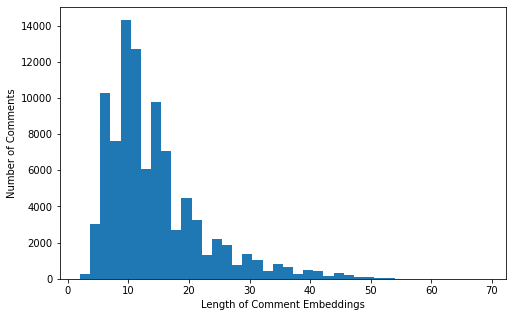

In [ ]:
# train
plot_sentence_embeddings_length(train_text_list, tokenizer)

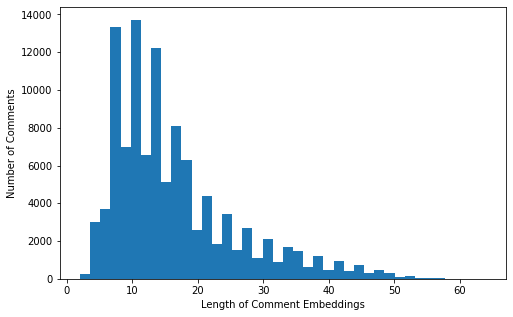

In [ ]:
# test
plot_sentence_embeddings_length(test_text_list, tokenizer)

### (2) Tokenize input texts into ids
*   Append the appropriate special characters to the end of the text to denote end of sentence.
*   Truncate or pad the appropriate sequence length.



In [ ]:
# 這裡可能要再改
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    # tokenize the text, then truncate sequence to the desired length minus 2 for the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

In [ ]:
# Create input id tokens (train)
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=50) # number of embeddings can be modified
train_input_ids

array([[   19, 23055,   463, ...,     0,     0,     0],
       [   19,  3687,  1879, ...,     0,     0,     0],
       [   19, 23055,   463, ...,     0,     0,     0],
       ...,
       [   19,  2917, 14632, ...,     0,     0,     0],
       [ 6459,  5331,  2400, ...,     0,     0,     0],
       [   19,  1448,    19, ...,     0,     0,     0]])

In [ ]:
# Create input id tokens (test)
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=50) # number of embeddings can be modified
test_input_ids

array([[   19,  1038,   227, ...,     0,     0,     0],
       [ 6749,  1804,  2050, ...,     0,     0,     0],
       [   19, 17261,    19, ...,     0,     0,     0],
       ...,
       [ 5062,  2114,  5489, ...,     0,     0,     0],
       [   19,  2565,   899, ...,     0,     0,     0],
       [ 4668,   670,   940, ...,     0,     0,     0]])

### (3) Create attention masks
*   Tell model whether attention should be applied to the input id tokens.
*   Do not want to perform attention on padding tokens.

In [ ]:
def create_attn_masks(input_ids):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# Create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

### (4) Add input ids and attention masks to the dataframe

In [ ]:
# train
train_valid["features"] = train_input_ids.tolist()
train_valid["masks"] = train_attention_masks
# test
test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [ ]:
train_valid.head()

,id,name,product,BB霜,CC霜,DD霜,RTD調酒,中式香腸,乳酸菌,人工淚液,...,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類,features,masks
0,1,槓片短槓心a,槓片,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 23055, 463, 1079, 23055, 256, 971, 4, 3, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,2,體育刻tuk奧林匹克槓片 – 125 25 5 kg tuk,槓片,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 3687, 1879, 620, 11818, 16277, 23055, 463...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,3,槓片短槓心a,槓片,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 23055, 463, 1079, 23055, 256, 971, 4, 3, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,4,槓片短槓心a,槓片,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 23055, 463, 1079, 23055, 256, 971, 4, 3, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,5,體育刻tuk奧林匹克槓片 – 125 25 5 kg tuk,槓片,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 3687, 1879, 620, 11818, 16277, 23055, 463...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
test.head()

,id,name,product,features,masks
0,1,施巴嬌顏卸妝乳ha,NaN,"[19, 1038, 227, 18341, 6819, 12264, 12937, 325...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,2,艾瑪絲舒敏平衡洗髮精,NaN,"[6749, 1804, 2050, 2763, 1841, 4315, 3002, 453...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,3,bb love高質感天絲tencel舖棉兩用兒童睡袋多款可選,NaN,"[19, 17261, 19, 2644, 5010, 98, 1844, 963, 118...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,4,lovita愛維他緩釋型維生素c,NaN,"[15344, 7234, 11442, 601, 635, 61, 5275, 5172,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,5,cm 長效rifle風扇 1200轉,NaN,"[19, 9928, 19, 155, 3775, 2883, 1219, 1407, 61...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## **3. Train, Valid Split (2022.06.09 updated)**


---



In [ ]:
# train valid
train, valid = train_test_split(train_valid, test_size=0.2, random_state=42)

In [ ]:
# find the random state that training and validating set has all the classes
best_state = 42
for i in range(1,200):
  if valid['product'].nunique() != class_num:
    train, valid = train_test_split(train_valid, test_size=0.2, random_state=i)
    if valid['product'].nunique() == class_num:
      best_state = i
    
print(best_state)

42


In [ ]:
print(train['product'].nunique())
print(valid['product'].nunique())

216
216


In [ ]:
# optional
train.to_csv("/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/model/品類-單標籤-final/xlnet_product_single_bcel_trainset.csv", index = False)
valid.to_csv("/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/model/品類-單標籤-final/xlnet_product_single_bcel_validset.csv", index = False)

In [ ]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

# products column names
label_cols = products.columns.values.tolist()
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

## **4. Create Dataloaders (torch tensors)**
---

Convert all of the input ids and attention masks into torch tensors, the required datatype for the model.


In [ ]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 32

# Create an iterator of our data with torch DataLoader. 
# With an iterator, the entire dataset does not need to be loaded into memory.
train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

## **5. Training**


---



### (1) Functions

Train the model and save the model with the lowest validation loss.

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i
    """
    Training
    """
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      # scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)
    print("Train loss: {}".format(epoch_train_loss))

    """
    Validation
    """
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()
    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    # Update tracking variables
    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)
    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set

Save the model to the path directory provided.

In [ ]:
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return

Load the model from the path directory provided.

In [ ]:
def load_model(save_path):
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

### (2) Train model from scratch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    # self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased') # for English
    self.xlnet = AutoModel.from_pretrained("hfl/chinese-xlnet-base") # for Chinese
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      # loss_fct = CrossEntropyLoss() # for single-label
      loss_fct = BCEWithLogitsLoss() # for multi-label
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Need GPU
# Modify output path
# Modify number of epochs (authors recommend 2 to 4)

num_epochs=5

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/model/品類-單標籤-final/xlnet_product_single_bcel.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.00034941159770436034
Valid loss: 4.6867041422941124e-05


Epoch:  20%|██        | 1/5 [13:30<54:03, 810.82s/it]

Saving model at epoch 0 with validation loss of 4.6867041422941124e-05


Train loss: 3.679614909053999e-05
Valid loss: 2.506247380224785e-05


Epoch:  40%|████      | 2/5 [26:58<40:26, 808.98s/it]

Saving model at epoch 1 with validation loss of 2.506247380224785e-05


Train loss: 1.997449885022882e-05
Valid loss: 2.0236232700052834e-05


Epoch:  60%|██████    | 3/5 [40:26<26:56, 808.49s/it]

Saving model at epoch 2 with validation loss of 2.0236232700052834e-05


Train loss: 1.285245554196397e-05


Epoch:  80%|████████  | 4/5 [53:52<13:27, 807.38s/it]

Valid loss: 2.038993057263344e-05


Train loss: 1.0007668849846272e-05
Valid loss: 1.5258103102893053e-05


Epoch: 100%|██████████| 5/5 [1:07:19<00:00, 807.87s/it]

Saving model at epoch 4 with validation loss of 1.5258103102893053e-05




Text(0.5, 1.0, 'Loss vs Number of Epochs')

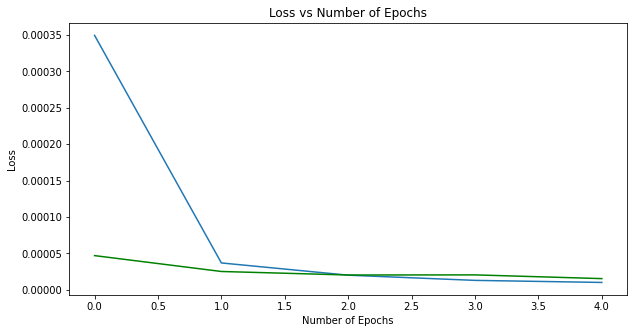

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

### (3) Train model from previous checkpoint

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/model/品類-單標籤-final/xlnet_product_single_bcel.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
num_epochs=5
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.947587202581162e-06


Epoch:  20%|██        | 1/5 [13:28<53:53, 808.43s/it]

Valid loss: 1.5297311251549487e-05


Train loss: 3.6429164964868076e-06


Epoch:  40%|████      | 2/5 [26:55<40:23, 807.85s/it]

Valid loss: 1.6055612096287302e-05


Train loss: 3.0586804116284483e-06


Epoch:  60%|██████    | 3/5 [40:23<26:55, 807.55s/it]

Valid loss: 1.631195085238004e-05


Train loss: 2.8831208219322042e-06


Epoch:  80%|████████  | 4/5 [53:49<13:27, 807.27s/it]

Valid loss: 1.5469858799640723e-05


Train loss: 2.818751089614596e-06


Epoch: 100%|██████████| 5/5 [1:07:16<00:00, 807.35s/it]

Valid loss: 1.7289908190382416e-05




Text(0.5, 1.0, 'Loss vs Number of Epochs')

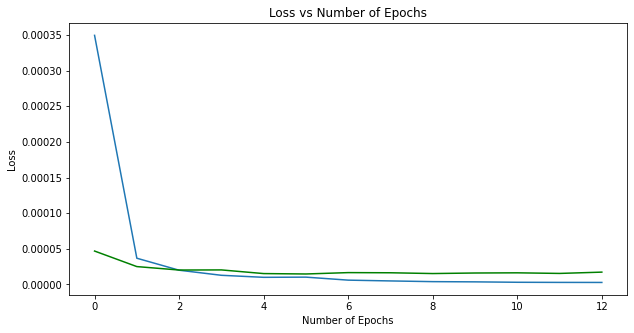

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## **6. Get Predictions**


---



### (1) Testing

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[2.36174941e-07, 1.39958274e-07, 4.11490788e-07, ...,
        1.83744214e-06, 1.02721117e-06, 3.49368529e-05],
       [1.14837215e-08, 5.19884864e-08, 8.24023004e-07, ...,
        7.63817752e-06, 5.42392343e-07, 6.91498371e-07],
       [2.33069542e-07, 1.71709729e-07, 2.95119230e-06, ...,
        9.78664275e-07, 2.32894209e-07, 1.73277440e-05],
       ...,
       [4.21175415e-08, 1.17594084e-07, 1.22338449e-07, ...,
        3.27835998e-08, 4.43785257e-06, 2.19893934e-08],
       [3.45035609e-08, 2.75123566e-05, 3.77267526e-07, ...,
        2.89218649e-09, 1.02634409e-07, 5.11898907e-06],
       [3.95560349e-08, 1.06698273e-07, 7.37150958e-06, ...,
        8.44018633e-09, 7.42102566e-06, 2.47088769e-06]])

In [ ]:
for i in label_cols:
  test[i] = pred_probs[:,label_cols.index(i)]

test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,product,features,masks,BB霜,CC霜,DD霜,RTD調酒,中式香腸,...,電磁爐,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類
0,1,施巴嬌顏卸妝乳ha,NaN,"[19, 1038, 227, 18341, 6819, 12264, 12937, 325...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.361749e-07,1.399583e-07,4.114908e-07,1.687855e-06,1.230470e-05,...,2.734814e-08,7.439552e-07,3.134345e-06,1.348492e-07,4.864381e-07,6.670207e-09,7.934725e-08,1.837442e-06,1.027211e-06,3.493685e-05
1,2,艾瑪絲舒敏平衡洗髮精,NaN,"[6749, 1804, 2050, 2763, 1841, 4315, 3002, 453...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.148372e-08,5.198849e-08,8.240230e-07,9.889199e-07,1.598032e-07,...,3.576305e-07,1.621331e-08,1.709999e-08,4.561782e-08,1.473271e-08,1.690744e-07,2.083766e-07,7.638178e-06,5.423923e-07,6.914984e-07
2,3,bb love高質感天絲tencel舖棉兩用兒童睡袋多款可選,NaN,"[19, 17261, 19, 2644, 5010, 98, 1844, 963, 118...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.330695e-07,1.717097e-07,2.951192e-06,3.049412e-06,3.027373e-06,...,5.986298e-07,3.391992e-07,1.293528e-08,1.050042e-08,3.492401e-06,1.560892e-07,3.108353e-05,9.786643e-07,2.328942e-07,1.732774e-05
3,4,lovita愛維他緩釋型維生素c,NaN,"[15344, 7234, 11442, 601, 635, 61, 5275, 5172,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.298690e-06,3.727025e-05,4.210173e-07,1.362470e-07,5.551099e-06,...,5.108490e-07,5.184426e-07,1.084234e-08,3.232793e-07,4.752401e-07,4.247505e-05,5.009936e-07,5.140819e-08,2.688114e-08,7.097497e-07
4,5,cm 長效rifle風扇 1200轉,NaN,"[19, 9928, 19, 155, 3775, 2883, 1219, 1407, 61...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.900539e-06,1.037098e-07,7.658747e-06,1.008649e-08,1.861273e-07,...,1.068328e-08,2.751145e-06,5.099452e-08,9.999958e-01,5.143065e-08,8.164983e-09,3.653217e-08,4.880570e-06,3.276637e-06,1.525383e-05


### (2) For single-label classification

In [ ]:
# Get the maximum probability for each row
test['product_predict'] = test.iloc[:,5:].idxmax(axis = 1)
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,product,features,masks,BB霜,CC霜,DD霜,RTD調酒,中式香腸,...,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類,product_predict
0,1,施巴嬌顏卸妝乳ha,NaN,"[19, 1038, 227, 18341, 6819, 12264, 12937, 325...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.361749e-07,1.399583e-07,4.114908e-07,1.687855e-06,1.230470e-05,...,7.439552e-07,3.134345e-06,1.348492e-07,4.864381e-07,6.670207e-09,7.934725e-08,1.837442e-06,1.027211e-06,3.493685e-05,卸妝乳
1,2,艾瑪絲舒敏平衡洗髮精,NaN,"[6749, 1804, 2050, 2763, 1841, 4315, 3002, 453...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.148372e-08,5.198849e-08,8.240230e-07,9.889199e-07,1.598032e-07,...,1.621331e-08,1.709999e-08,4.561782e-08,1.473271e-08,1.690744e-07,2.083766e-07,7.638178e-06,5.423923e-07,6.914984e-07,洗髮精
2,3,bb love高質感天絲tencel舖棉兩用兒童睡袋多款可選,NaN,"[19, 17261, 19, 2644, 5010, 98, 1844, 963, 118...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.330695e-07,1.717097e-07,2.951192e-06,3.049412e-06,3.027373e-06,...,3.391992e-07,1.293528e-08,1.050042e-08,3.492401e-06,1.560892e-07,3.108353e-05,9.786643e-07,2.328942e-07,1.732774e-05,睡袋
3,4,lovita愛維他緩釋型維生素c,NaN,"[15344, 7234, 11442, 601, 635, 61, 5275, 5172,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.298690e-06,3.727025e-05,4.210173e-07,1.362470e-07,5.551099e-06,...,5.184426e-07,1.084234e-08,3.232793e-07,4.752401e-07,4.247505e-05,5.009936e-07,5.140819e-08,2.688114e-08,7.097497e-07,維他命C
4,5,cm 長效rifle風扇 1200轉,NaN,"[19, 9928, 19, 155, 3775, 2883, 1219, 1407, 61...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.900539e-06,1.037098e-07,7.658747e-06,1.008649e-08,1.861273e-07,...,2.751145e-06,5.099452e-08,9.999958e-01,5.143065e-08,8.164983e-09,3.653217e-08,4.880570e-06,3.276637e-06,1.525383e-05,電風扇
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108843,108844,歐舒丹橙花蘭花護手霜,NaN,"[19, 1246, 2763, 948, 12548, 265, 670, 265, 22...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.067839e-07,3.671852e-07,3.310443e-08,2.831724e-08,9.457109e-08,...,3.250925e-07,1.754595e-07,2.812478e-07,1.300869e-08,1.458757e-06,1.722215e-08,3.032051e-08,6.336415e-08,4.894583e-05,護手霜
108844,108845,高露潔 360度抗敏專家牙刷,NaN,"[5062, 2114, 5489, 19, 7286, 305, 1952, 1841, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.870716e-08,1.629331e-07,2.271528e-07,1.339490e-07,6.171282e-06,...,8.522105e-07,3.874518e-08,1.149271e-05,1.991778e-08,3.474234e-06,6.698447e-09,5.710831e-08,5.580260e-06,1.835584e-08,成人牙刷
108845,108846,高露潔專業型超小刷頭密植軟毛牙刷裝康是美,NaN,"[5062, 2114, 5489, 3273, 263, 738, 96, 10606, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.211754e-08,1.175941e-07,1.223384e-07,1.555379e-07,5.797312e-06,...,9.472161e-07,4.383259e-08,6.732856e-06,3.921910e-08,4.949680e-06,7.410107e-09,3.278360e-08,4.437853e-06,2.198939e-08,成人牙刷
108846,108847,熊寶貝 沁藍海洋香柔軟衣物護衣精2 x2x,NaN,"[19, 2565, 899, 1091, 19, 10835, 1684, 2811, 8...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.450356e-08,2.751236e-05,3.772675e-07,6.916000e-08,1.200565e-07,...,2.881680e-07,2.857517e-08,7.498375e-08,3.998132e-09,4.023581e-06,1.855286e-07,2.892186e-09,1.026344e-07,5.118989e-06,柔軟精


### (3) Save the predicting results

In [ ]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/第四組/output/final/xlnet_product_single_predict_bcel.csv")
test.to_csv(pred_save_path, index=False)

## **7. Evaluate Validation Set**


---



In [ ]:
valid_data = valid[["id", "name", "product", "features", "masks"]]
valid_data

,id,name,product,features,masks
35852,35853,pyuan 純漾 活力星彩洗髮精,洗髮精,"[19, 16832, 1507, 1884, 19, 3561, 23818, 19, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
7323,7324,ora2淨白無瑕牙膏清蘋玫瑰薄荷,成人牙膏,"[19, 13639, 45, 5876, 259, 285, 23898, 2665, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
73604,73605,威德清涼果凍 能量裝,維他命飲料,"[19, 694, 79, 296, 6859, 984, 9795, 19, 3283, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
66744,66745,時時樂限定adidas 女款休閒鞋 五款c款藍uk6,運動鞋,"[19, 71, 71, 774, 9051, 2400, 18718, 150, 19, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
6293,6294,高露潔 高密細絲護齦牙刷 顏色隨機,成人牙刷,"[5062, 2114, 5489, 5062, 803, 2535, 2050, 2267...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...
79344,79345,幸福時光貓營養主食罐雞肉鮪魚,貓乾糧罐頭,"[19, 7765, 71, 182, 3378, 13419, 267, 807, 988...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
321,322,all clean 兒童伯肯鞋軍綠,水路/健行鞋,"[19, 5331, 19, 18187, 1884, 19, 2996, 507, 260...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
85194,85195,韓國mamicook頂級藍寶鈦金鑽不沾深炒鍋深炒鍋,鍋具,"[19, 1448, 2674, 16981, 10771, 15307, 1684, 89...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5182,5183,panasonic 國際牌一級能效雙門變頻冰箱—星耀黑nrb420tva,冰箱,"[6459, 7130, 2920, 3095, 19, 514, 977, 7551, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


### (1) Predicting

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, valid_data, num_labels, device="cuda", batch_size=32)
for i in label_cols:
  valid_data[i] = pred_probs[:,label_cols.index(i)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


In [ ]:
# Get the maximum probability for each row
valid_data['product_predict'] = valid_data.iloc[:,5:].idxmax(axis = 1)
valid_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,product,features,masks,BB霜,CC霜,DD霜,RTD調酒,中式香腸,...,電視遊戲機,電鍋,電風扇,面膜,面霜/乳霜,香氛機,香氛蠟燭,鮮乳,麥片穀類,product_predict
35852,35853,pyuan 純漾 活力星彩洗髮精,洗髮精,"[19, 16832, 1507, 1884, 19, 3561, 23818, 19, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.496904e-09,4.304287e-08,5.860762e-07,5.731854e-07,2.414667e-07,...,8.385933e-09,2.155869e-08,5.637186e-08,2.049977e-08,9.393146e-08,2.983399e-07,3.940520e-06,5.096549e-07,5.846549e-07,洗髮精
7323,7324,ora2淨白無瑕牙膏清蘋玫瑰薄荷,成人牙膏,"[19, 13639, 45, 5876, 259, 285, 23898, 2665, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.426655e-08,1.812103e-07,2.416637e-09,6.916632e-07,2.167011e-07,...,8.768341e-07,2.682767e-08,7.004948e-07,1.886576e-08,1.824839e-08,1.491035e-06,6.748649e-07,5.562093e-08,8.324349e-07,成人牙膏
73604,73605,威德清涼果凍 能量裝,維他命飲料,"[19, 694, 79, 296, 6859, 984, 9795, 19, 3283, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.349975e-05,3.595534e-06,1.330688e-06,4.146604e-07,4.311763e-06,...,2.750016e-05,1.186895e-06,3.763875e-06,3.381034e-07,1.281967e-05,6.863102e-06,6.847261e-07,5.125364e-05,3.712261e-05,維他命飲料
66744,66745,時時樂限定adidas 女款休閒鞋 五款c款藍uk6,運動鞋,"[19, 71, 71, 774, 9051, 2400, 18718, 150, 19, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.789833e-06,3.614080e-08,3.240057e-06,7.045313e-07,4.186877e-08,...,1.428464e-07,5.265321e-08,2.322196e-07,3.383549e-08,2.398267e-07,1.752233e-10,6.518783e-10,1.104552e-06,1.805939e-07,運動鞋
6293,6294,高露潔 高密細絲護齦牙刷 顏色隨機,成人牙刷,"[5062, 2114, 5489, 5062, 803, 2535, 2050, 2267...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.606136e-08,1.414770e-07,2.047529e-07,1.136866e-07,1.058780e-05,...,1.476763e-06,5.683557e-08,1.146373e-05,2.415067e-08,5.558622e-06,1.654413e-08,3.653531e-08,1.342278e-05,1.457524e-08,成人牙刷
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79344,79345,幸福時光貓營養主食罐雞肉鮪魚,貓乾糧罐頭,"[19, 7765, 71, 182, 3378, 13419, 267, 807, 988...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.016045e-08,1.071228e-07,1.785789e-08,8.624553e-08,3.006998e-06,...,1.169299e-07,3.119987e-07,1.805195e-06,3.317370e-09,1.667544e-07,2.461198e-07,1.148856e-07,1.277825e-07,2.145780e-07,貓乾糧罐頭
321,322,all clean 兒童伯肯鞋軍綠,水路/健行鞋,"[19, 5331, 19, 18187, 1884, 19, 2996, 507, 260...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.327794e-07,5.254193e-06,5.076345e-07,2.344346e-06,5.374118e-08,...,9.659004e-08,6.087967e-07,1.670468e-06,1.330841e-06,2.784722e-09,4.713873e-08,1.930676e-07,7.849766e-08,8.176176e-05,水路/健行鞋
85194,85195,韓國mamicook頂級藍寶鈦金鑽不沾深炒鍋深炒鍋,鍋具,"[19, 1448, 2674, 16981, 10771, 15307, 1684, 89...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.079969e-08,1.213055e-05,2.745842e-08,6.999028e-09,2.278309e-06,...,3.675610e-09,1.743221e-07,6.487966e-08,7.160487e-08,4.883904e-08,5.843827e-09,5.270958e-08,2.514952e-06,1.770967e-07,鍋具
5182,5183,panasonic 國際牌一級能效雙門變頻冰箱—星耀黑nrb420tva,冰箱,"[6459, 7130, 2920, 3095, 19, 514, 977, 7551, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.205403e-09,6.099482e-09,2.637171e-06,4.530419e-05,3.611959e-07,...,3.930470e-08,7.577230e-09,1.072895e-07,1.513918e-06,4.275678e-07,1.523492e-07,6.480216e-07,6.673411e-06,1.133520e-05,冰箱


### (2) Evaluation

In [ ]:
y_valid = valid_data['product']
y_valid_predict = valid_data['product_predict']

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, y_valid_predict)

0.9915024695947741

In [ ]:
# Macro F1
from sklearn.metrics import f1_score
f1_score(y_valid, y_valid_predict, average='macro')

0.9837287844862767

In [ ]:
# Precision, Recall & F1
from sklearn.metrics import classification_report
report = classification_report(y_valid, y_valid_predict, labels=np.unique(y_valid_predict))
print(report)

              precision    recall  f1-score   support

         BB霜       0.95      1.00      0.98        20
         CC霜       1.00      1.00      1.00         8
         DD霜       1.00      1.00      1.00        24
       RTD調酒       0.99      0.99      0.99       101
        中式香腸       1.00      0.98      0.99        65
         乳酸菌       1.00      1.00      1.00         9
        人工淚液       1.00      1.00      1.00        29
         保久乳       0.96      0.92      0.94        51
         保溫杯       1.00      1.00      1.00        16
         保險套       1.00      1.00      1.00        97
          修容       0.92      1.00      0.96        23
         健腹器       1.00      1.00      1.00        20
          優格       1.00      0.98      0.99       105
         優酪乳       0.99      1.00      0.99        67
       兒童漱口水       1.00      1.00      1.00        20
        兒童牙刷       1.00      0.94      0.97        80
        兒童牙膏       1.00      1.00      1.00        61
    其他地墊(家用)       0.97    